# Capstone Project 2: Twitter Public Opinion Network Analysis for Bungie

## Data Storytelling

This project's goal is to collect and analyze the available Twitter data for Bungie and their main game, Destiny 2.

This notebook is the data storytelling for the project. I'm going to visualize the numerical parts of the data, like retweet and favorite counts, as well as the follower counts of users in my dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from datetime import datetime
import seaborn as sns
sns.set()

%load_ext watermark
%watermark

2019-05-06T10:19:59

CPython 2.7.15
IPython 5.8.0

compiler   : MSC v.1500 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [3]:
# These are the datetime columns
# Pandas can convert them all as-is
datetime_cols = ['created_at', 'quoted_status.created_at', 'retweeted_status.created_at']

In [4]:
destiny_2_tweet_min_df = pd.read_csv("../data/destiny_2_tweets_min.csv",
                                     encoding='utf-8', index_col=0, parse_dates=datetime_cols)
bungie_tweet_min_df = pd.read_csv("../data/bungie_tweets_min.csv",
                                  encoding='utf-8', index_col=0, parse_dates=datetime_cols)
bungie_timeline_min_df = pd.read_csv("../data/bungie_timeline_min.csv",
                                     encoding='utf-8', index_col=0, parse_dates=datetime_cols)
destiny_2_timeline_min_df = pd.read_csv("../data/destiny_2_timeline_min.csv",
                                        encoding='utf-8', index_col=0, parse_dates=datetime_cols)

### What should I visualize?

Let's see what columns look good. All dataframes have the same columns.

We should look at created_at, retweet_count, and favorite_count. We can then average the latter two over small periods of time, and then show the averages as functions of tweet creation time.

We can also look at the same parameters for retweeted and quoted tweets.

In [5]:
destiny_2_tweet_min_df.columns

Index([u'id', u'created_at', u'text', u'user.id', u'user.name',
       u'user.screen_name', u'user.followers_count', u'user.friends_count',
       u'user.statuses_count', u'user.verified', u'favorite_count',
       u'retweet_count', u'retweeted', u'in_reply_to_screen_name',
       u'in_reply_to_status_id', u'in_reply_to_user_id', u'is_quote_status',
       u'quoted_status.id', u'quoted_status.created_at', u'quoted_status.text',
       u'quoted_status.user.id', u'quoted_status.user.followers_count',
       u'quoted_status.user.friends_count',
       u'quoted_status.user.statuses_count', u'quoted_status.user.verified',
       u'quoted_status.favorite_count', u'quoted_status.retweet_count',
       u'quoted_status.retweeted', u'quoted_status.in_reply_to_screen_name',
       u'quoted_status.in_reply_to_status_id',
       u'quoted_status.in_reply_to_user_id', u'quoted_status_id',
       u'quoted_status.user.following', u'quoted_status.is_quote_status',
       u'retweeted_status.id', u'retwee

Name the dataframes so that I can distinguish them more easily if I plot data from all of them together.

In [6]:
destiny_2_tweet_min_df.name = 'Destiny 2 Tweets'
bungie_tweet_min_df.name = 'Bungie Tweets'
bungie_timeline_min_df.name = 'Bungie Timeline'
destiny_2_timeline_min_df.name = 'Destiny 2 Timeline'

### Distribution of retweet counts

In [7]:
# Make sure I know how many bins to make
bins = (destiny_2_tweet_min_df['retweet_count'].max() - destiny_2_tweet_min_df['retweet_count'].min()) / 1000
bins

134.97200000000001

In [8]:
def plot_all_df_hist(df_list, col, bins):
    """For each dataframe in the list
    Plot the given column on a histogram, overlaid together
    """
    # Find the largest number in the col of any dataframe
    # This will be the uppermost bin
    max_bin = 0
    for df in df_list:
        if df[col].max() > max_bin:
            max_bin = df[col].max()
    
    # Set up figure
    fig, ax = plt.subplots()
    bins = np.linspace(0, max_bin, num=bins)
    
    # Loop over dataframe list
    for df in df_list:
        # Make a histogram for the column on the same plot
        df.plot.hist(y=col, label=df.name, ax=ax, log=True, bins=bins, alpha=0.7)
        
    # Set lower y-limit to visualize single counts
    ax = plt.ylim(ymin=0.1)
    ax = plt.ylabel('Log-Scaled Frequency')
    return ax

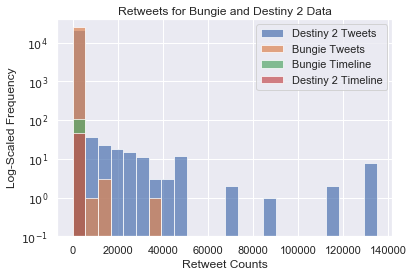

In [9]:
df_list = [destiny_2_tweet_min_df, bungie_tweet_min_df, bungie_timeline_min_df, destiny_2_timeline_min_df]
_ = plot_all_df_hist(df_list, 'retweet_count', 25)
_ = plt.xlabel('Retweet Counts')
_ = plt.title('Retweets for Bungie and Destiny 2 Data')
_ = plt.savefig('../analysis_images/retweet_hist.png')

This plot shows that the tweets about Destiny 2 have overwhelmingly more retweets than the other 3 dataframes. The Bungie tweets number as many as Destiny 2 tweets, but are heavily concentrated into the first bin. It is a little hard to see, but the Bungie tweets and Destiny 2 tweets almost completely overlap in the first bin.

The timeline dataframes are significantly smaller, and also only present in the first bin, but number two orders of magnitude lower than the Bungie tweets.

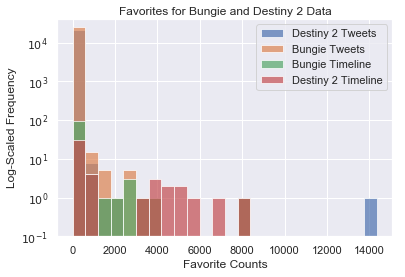

In [10]:
_ = plot_all_df_hist(df_list, 'favorite_count', 25)
_ = plt.xlabel('Favorite Counts')
_ = plt.title('Favorites for Bungie and Destiny 2 Data')
_ = plt.savefig('../analysis_images/favorites_hist.png')

Favorites have a much smaller variance than retweets, and the timeline datasets have some decently high favorite counts. This makes sense, as the official Destiny 2 and Bungie accounts probably have as much, if not more, engagement as any tweet about them from someone else.

The first bin still has the majority of the data of each dataframe.

#### Correlate retweet and favorite counts

In [11]:
def plot_all_df_scatter(df_list, xcol, ycol):
    """For each dataframe in the list
    Plot (xcol, ycol) as a scatter plot 
    Overlaid together
    """
    
    # Colormap
    colors = cm.get_cmap('Accent')
    
    # Set up figure
    fig, ax = plt.subplots()
    #bins = np.linspace(0, max_bin, num=bins)
    
    # Loop over dataframe list
    for idx, df in enumerate(df_list):
        # Make a histogram for the column on the same plot
        df.plot.scatter(x=xcol, y=ycol, label=df.name, ax=ax, c=colors(idx), alpha=0.5)
        
    # Set lower y-limit to visualize single counts
    #ax = plt.ylim(ymin=0.1)
    #ax = plt.ylabel('Log-Scaled Frequency')
    ax = plt.legend()
    return ax

Okay. This is interesting, since it looks like tweets either have a lot of retweets or a lot of favorites, but not both. Let's log scale both axes and see if it looks any different.

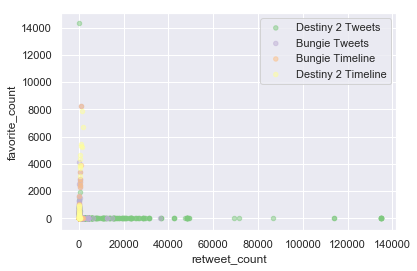

In [12]:
_ = plot_all_df_scatter(df_list, 'retweet_count', 'favorite_count')

This trend is more of what I expected, but I didn't expect to log-log-scale to get it.

I thought the retweets were higher numbers than favorites, but that's only because there were huge outliers!

Most tweets have more favorites that retweets.

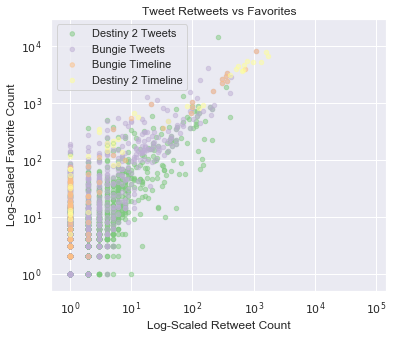

In [13]:
plt.rcParams["figure.figsize"] = (6,5)
_ = plot_all_df_scatter(df_list, 'retweet_count', 'favorite_count')
_ = plt.yscale('log')
_ = plt.ylim([0.5, 30000])
_ = plt.xscale('log')
_ = plt.xlim([0.5, 145000])
_ = plt.ylabel('Log-Scaled Favorite Count')
_ = plt.xlabel('Log-Scaled Retweet Count')
_ = plt.title('Tweet Retweets vs Favorites')
_ = plt.savefig('../analysis_images/favorites_vs_retweets_log_log.png')

#### Time Series Plots

The first function makes the first few sets of plots. It's not very useful, so I made the second function.

In [14]:
def plot_vs_time(df_list, time_col, plot_col):
    """For each dataframe in the list
    Plot plot_col as a function of time_col
    Overlaid together
    
    """
    
    # Colormap
    colors = cm.get_cmap('Accent')
    
    # Set up figure
    # Make a different figure for each df!
    fig, axes = plt.subplots(len(df_list), 1)
    fig.set_size_inches(16, 12)
    
    # Loop over dataframe list
    for idx, df in enumerate(df_list):
        # Consider formatting the x-axis better
        
        # Consider averaging, or having that as an optional parameter
        
        # If you want them to all be on the same plot, normalize the counts by follower count or something.
        
        # Make a histogram for the column on the same plot
        df.plot.line(x=time_col, y=plot_col, label=df.name, ax=axes[idx], c=colors(idx))
        
    # Set lower y-limit to visualize single counts
    #ax = plt.ylim(ymin=0.1)
    #ax = plt.ylabel('Log-Scaled Frequency')
    #ax = plt.legend()
    return fig

In [36]:
def plot_grid_cols_vs_time(df_list, time_col, plot_cols):
    """For each dataframe in the list
    Plot each plot_col as a function of time_col
    
    The output will be an arrangement of plots
    With a width the same as df_list
    And a height the same as plot_cols    
    """
    
    # Colormap
    colors = cm.get_cmap('Accent')
    
    # Set up figure
    # Different figure for each df and plotting column
    fig, axes = plt.subplots(len(plot_cols), len(df_list))
    fig.set_size_inches(20, 12)
    
    # Loop over dataframe list
    for col, df in enumerate(df_list):
        # Set the dataframe as the title for the column
        axes[0][col].set_title(df.name, fontsize=30)
        
        # Loop over column list
        for row, plot_col in enumerate(plot_cols):
            
            # Plotting
            df.plot.line(x=time_col, y=plot_col, label=df.name, ax=axes[row][col], c=colors(row+4))
        
            # Formatting
            axes[row][0].set_ylabel(plot_col, fontsize=30)
            axes[row][col].set_xlabel('Day of March', fontsize=20)
            axes[row][col].xaxis.set_major_locator(matplotlib.dates.DayLocator())
            axes[row][col].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d"))
            axes[row][col].tick_params(axis='both', which='major', labelsize=15)
            axes[row][col].tick_params(axis='both', which='minor', labelsize=10)

            # Don't want the date text rotated
            for tick in axes[row][col].get_xticklabels():
                tick.set_rotation(0)
            
    fig.suptitle('Engagement Metrics Across All Datasets', fontsize=40)
    
    return fig

#### The drastically different scales prevent these graphs from being a useful comparison.

I could plot them independently. I have now done this.

I could average over 5 minute windows.

I could normalize the counts by follower count.

It might also be nice to look at a single dataset and compare the retweets and favorites over time. (This is done just below)

I see that I got more tweets about Bungie per unit time. The Bungie Tweets part of this graph does not extend back as far in time, but has more tweets. Interesting.

Overall these graphs aren't super interesting or useful. I can do better.

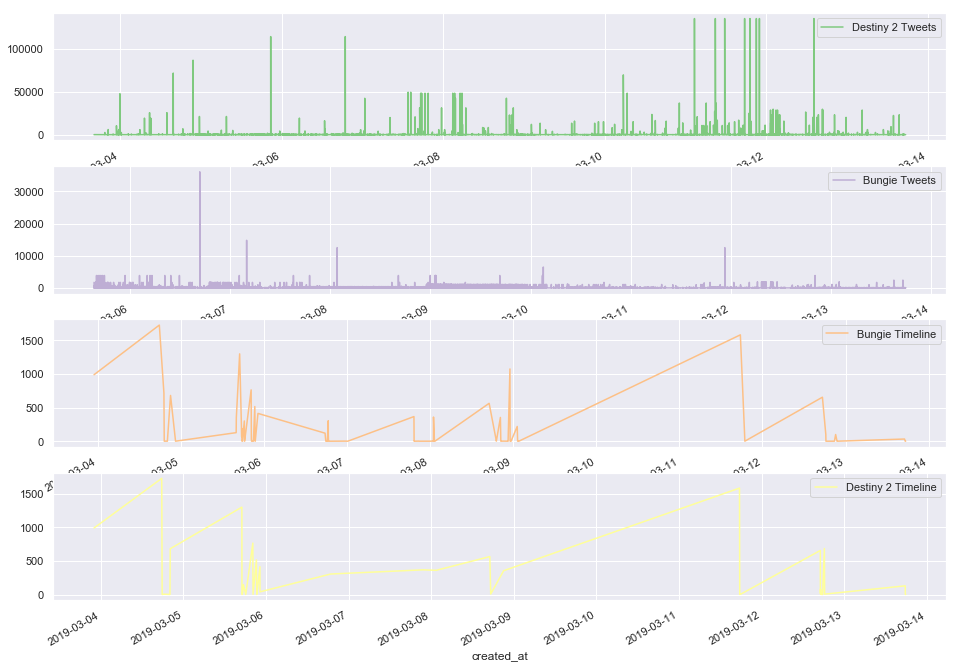

In [16]:
_ = plot_vs_time(df_list, 'created_at', 'retweet_count')

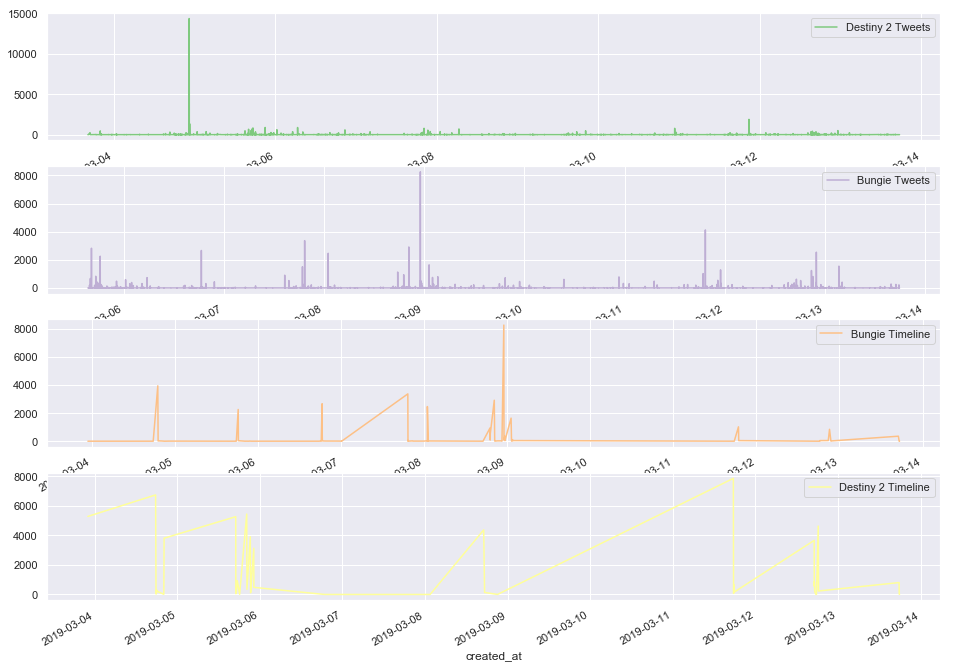

In [17]:
_ = plot_vs_time(df_list, 'created_at', 'favorite_count')

#### These plots are much more useful

This plotting pattern allows me to look for time correlations within a dataset (since a datasets columns are stacked vertically).

I can also compare the scales of the same columns across datasets, since a column is presented across dataframes horizontally.

The Destiny 2 Timeline tweets have some strong time correlations for retweet and favorite counts.

The Bungie Timeline tweets have a little correlation for the counts.

The other tweets don't really have any correlation.

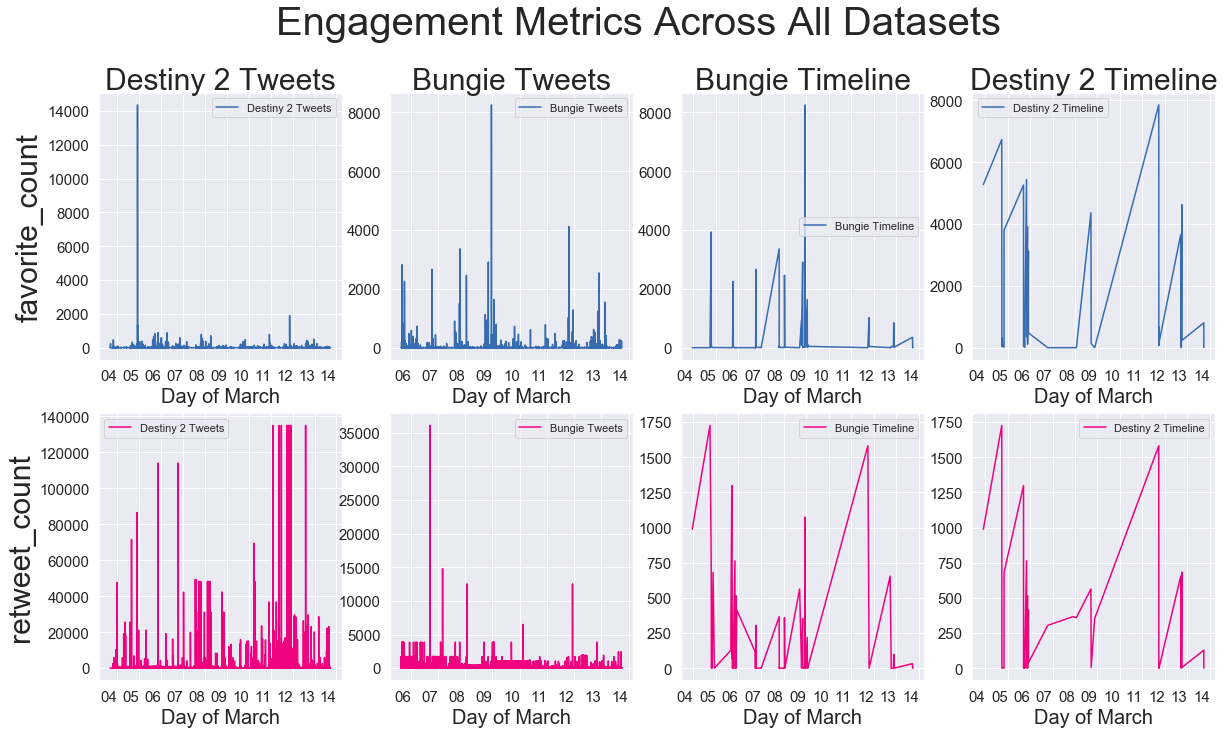

In [37]:
plt.rcParams["figure.figsize"] = (12,8)
_ = plot_grid_cols_vs_time(df_list, 'created_at',
                           ['favorite_count', 'retweet_count'])

_ = plt.savefig('../analysis_images/time_series_retweets_and_favorites.png')

# Set back to default
plt.rcParams["figure.figsize"] = (6,5)

### Time Averaging

If I set the index to be the tweet creation time, I can resample and average much more easily.

The following code sets the index to the column 'created_at,' resamples to only have each hour, and then takes the mean of each numeric column, then plots the retweet and favorite counts. It's interesting that the spikes don't correspond with each other.

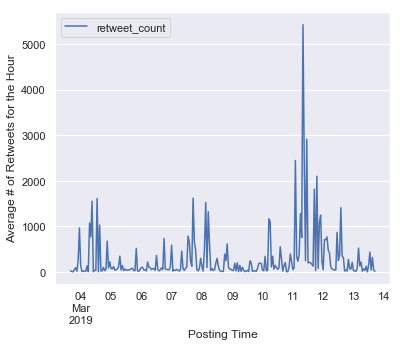

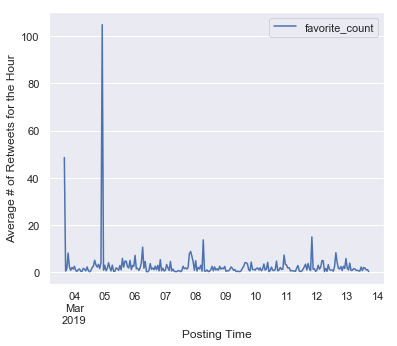

In [19]:
_ = destiny_2_tweet_min_df.set_index('created_at'
                                    ).resample('1H'
                                              ).mean().plot(y='retweet_count')
_ = plt.ylabel('Average # of Retweets for the Hour')
_ = plt.xlabel('Posting Time')

_ = destiny_2_tweet_min_df.set_index('created_at'
                                    ).resample('1H'
                                              ).mean().plot(y='favorite_count')
_ = plt.ylabel('Average # of Retweets for the Hour')
_ = plt.xlabel('Posting Time')

### Visualize engagement metrics vs follower count

Will do normal-scale and log-scale versions of both

I figure there should be some correlation. It makes sense that users with larger follower bases will have more interaction on their tweets.

#### Favorite Count

This plot shows a little. It's immediately clear that there isn't a simple relationship between follower base and tweet interaction.

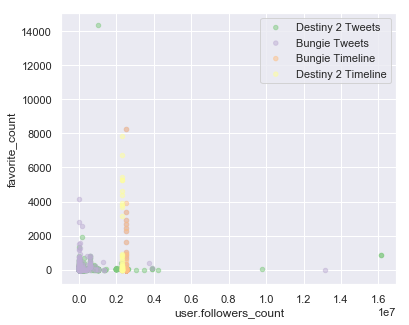

In [20]:
_ = plot_all_df_scatter(df_list, 'user.followers_count', 'favorite_count')

Log-scaling, we can see that the Bungie and Destiny Timelines are from only one user, so they only have one user follower count (new users subscribe over time, but that's a small change compared to the existing follower count).

The top of the distribution from the bulk of the tweets (purple / green) is almost linear on the log-log scale. This mildly supports the idea that getting to a certain interaction level requires a certain size of follower base. Tweets with less interaction are always possible, if you post during a time of low activity (middle of the night) or have a less interesting thing to say.

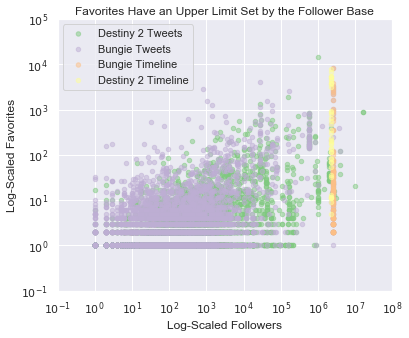

In [21]:
_ = plot_all_df_scatter(df_list, 'user.followers_count', 'favorite_count')
_ = plt.xscale('log')
_ = plt.xlim([0.1, 100000000])
_ = plt.yscale('log')
_ = plt.ylim([0.1, 100000])
_ = plt.ylabel('Log-Scaled Favorites')
_ = plt.xlabel('Log-Scaled Followers')
_ = plt.title('Favorites Have an Upper Limit Set by the Follower Base')
_ = plt.savefig('../analysis_images/favorites_vs_followers_log_log.png')

#### Retweet Count

This definitely needs the log scaling.

This has the same problem as an earlier plot: the huge scale of the retweet counts makes the data look like it just lies on the axes.

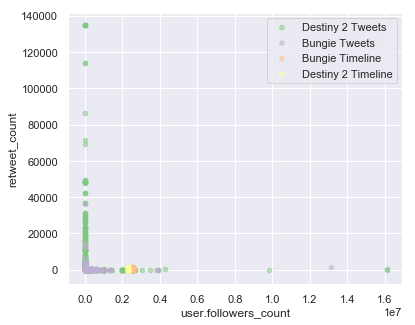

In [22]:
_ = plot_all_df_scatter(df_list, 'user.followers_count', 'retweet_count')

Here, there is less of a correlation. It just seems like a block of data.

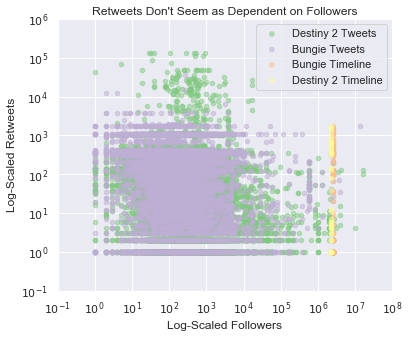

In [23]:
_ = plot_all_df_scatter(df_list, 'user.followers_count', 'retweet_count')
_ = plt.xscale('log')
_ = plt.xlim([0.1, 100000000])
_ = plt.yscale('log')
_ = plt.ylim([0.1, 1000000])
_ = plt.ylabel('Log-Scaled Retweets')
_ = plt.xlabel('Log-Scaled Followers')
_ = plt.title('Retweets Don\'t Seem as Dependent on Followers')
_ = plt.savefig('../analysis_images/retweets_vs_followers_log_log.png')

All of these plots seem to indicate that most tweets have fewer retweets / favorites than the posting user has followers, but there are a decent number of exceptions. Those tweets could have interesting data to analyze with NLP.

### Normalize counts by Follower number



In [24]:
def plot_data_normalized_vs_time(df_list, plot_col, norm_col, time_col, resampling):
    """
    Plots plot_col normalized by norm_col
    vs time_col, resampled with the resampling string
    For each dataframe in df_list
    """
    
    # Make sure the input is correct
    assert type(resampling) == str
    for df in df_list:
        assert plot_col in df
        assert norm_col in df
        assert time_col in df
    
    # Colormap
    colors = cm.get_cmap('Accent')
    
    # Set up figure
    fig, ax = plt.subplots()
    
    # Loop
    for idx, df in enumerate(df_list):
        # Need to make the time column the index
        # Then we can resample
        df_time_idx = df.set_index(time_col)
        
        # Need to make the normalized column
        df_time_idx['normalized'] = df_time_idx[plot_col] / df_time_idx[norm_col]
        
        df_time_idx.resample(resampling).mean().plot.line(y='normalized',
                                                          label=df.name,
                                                          ax=ax,
                                                          color=colors(idx),
                                                          legend=None)
        
    return fig

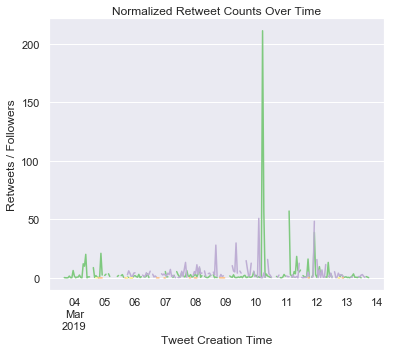

In [25]:
_ = plot_data_normalized_vs_time(df_list, 'retweet_count', 'user.followers_count', 'created_at', '1H')
_ = plt.ylabel('Retweets / Followers')
_ = plt.xlabel('Tweet Creation Time')
_ = plt.title('Normalized Retweet Counts Over Time')

It seems like favorites and retweets are on very different scales. However, that may just be because of a few tweets with huge retweet counts.

The Timelines barely register on these plots. Normalizing by follower count probably makes their y-values very small.

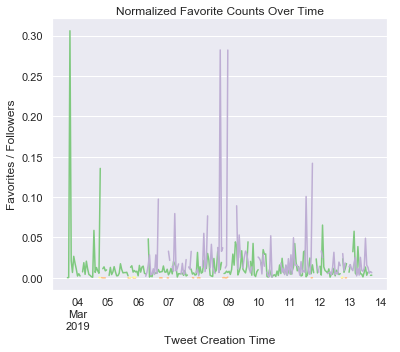

In [26]:
_ = plot_data_normalized_vs_time(df_list, 'favorite_count', 'user.followers_count', 'created_at', '1H')
_ = plt.ylabel('Favorites / Followers')
_ = plt.xlabel('Tweet Creation Time')
_ = plt.title('Normalized Favorite Counts Over Time')

Let's try log-scaling the y-axes of both those plots.

C:\Users\sebia\Miniconda2\lib\site-packages\matplotlib\scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


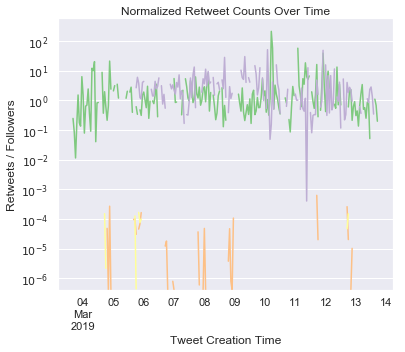

In [27]:
_ = plot_data_normalized_vs_time(df_list, 'retweet_count', 'user.followers_count', 'created_at', '1H')
_ = plt.yscale('log')
_ = plt.ylabel('Retweets / Followers')
_ = plt.xlabel('Tweet Creation Time')
_ = plt.title('Normalized Retweet Counts Over Time')

Both of these show similar trends. The timeline tweets for the official accounts have lots of followers, and so they register very low on this normalized scale.

Additionally, it is clear to see that in general, there are more retweets than favorites.

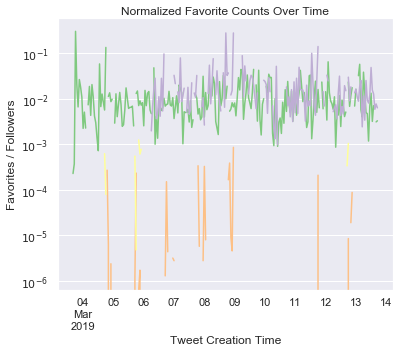

In [28]:
_ = plot_data_normalized_vs_time(df_list, 'favorite_count', 'user.followers_count', 'created_at', '1H')
_ = plt.yscale('log')
_ = plt.ylabel('Favorites / Followers')
_ = plt.xlabel('Tweet Creation Time')
_ = plt.title('Normalized Favorite Counts Over Time')

### How often do retweets occur in my data?

In [29]:
def calculate_percentage_nonnan(df, col):
    print("%d entries in DataFrame" % len(df))
    print("%d entries in %s" % (len(df[col].dropna()), col))
    print("This is %f of the data" % (1.0 * len(df[col].dropna())/len(df)))

In [30]:
for df in df_list:
    print(df.name)
    calculate_percentage_nonnan(df, 'retweeted_status.id')
    print('')

Destiny 2 Tweets
21439 entries in DataFrame
8763 entries in retweeted_status.id
This is 0.408741 of the data

Bungie Tweets
24729 entries in DataFrame
8134 entries in retweeted_status.id
This is 0.328926 of the data

Bungie Timeline
107 entries in DataFrame
17 entries in retweeted_status.id
This is 0.158879 of the data

Destiny 2 Timeline
46 entries in DataFrame
4 entries in retweeted_status.id
This is 0.086957 of the data



### Quoted statuses?

In [31]:
for df in df_list:
    print(df.name)
    calculate_percentage_nonnan(df, 'quoted_status.id')
    print('')

Destiny 2 Tweets
21439 entries in DataFrame
209 entries in quoted_status.id
This is 0.009749 of the data

Bungie Tweets
24729 entries in DataFrame
398 entries in quoted_status.id
This is 0.016094 of the data

Bungie Timeline
107 entries in DataFrame
12 entries in quoted_status.id
This is 0.112150 of the data

Destiny 2 Timeline
46 entries in DataFrame
1 entries in quoted_status.id
This is 0.021739 of the data



Let's visualize those numbers.

In [32]:
def plot_percentage_of_df(df_list, col_list):
    """
    For each dataframe
    I want the number of non-null entries in each col
    in col_list as a bar
    """
    # Set up dataframe to collect statistics
    stats_df = pd.DataFrame(index=[df.name for df in df_list],
                            columns=[col for col in col_list])
    
    # Collect statistics
    for df in df_list:
        for col in col_list:
            stats_df.loc[df.name, col] = (100 * len(df[col].dropna())/len(df))
            
    # Set up figure
    fig, ax = plt.subplots()
    
    # Number of bar clusters
    bar_clusters = np.arange(len(df_list))
    width = 0.10
    
    # Plot
    for col_num, col in enumerate(col_list):
        ax.bar(left=bar_clusters + width * col_num,
               height=stats_df.loc[:,col].values,
               width=width, 
               label=col)
    
    # Formatting
    ax.set_xticks(bar_clusters + width / 2)
    ax.set_xticklabels([df.name for df in df_list])
    ax.set_ylabel('Percentage Non-Null Data')
    fig = plt.legend()
    
    return fig

The blue bar is just any kind of tweet, so 100% of the data is valid tweets after data cleaning.

Here we can more easily see that retweeting is much more common than quoting, and constitutes a significant portion of tweets.

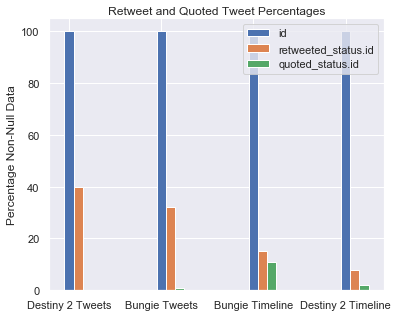

In [33]:
col_list = ['id', 'retweeted_status.id', 'quoted_status.id']
_ = plot_percentage_of_df(df_list, col_list)
_ = plt.title('Retweet and Quoted Tweet Percentages')
_ = plt.savefig('../analysis_images/tweet_types_bar_chart.png')